In [1]:
# import statements
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
# Threshold for drawing edges in EOSG
theta2 = 0.7125

# Threshold for drawing edges in final timeline 
theta3 = 0.4

In [17]:
# Vectorizing 
data = pd.read_csv("dummy_data.csv")
roberta = SentenceTransformer('stsb-roberta-base')

In [18]:
v = utils.encode([x + ': ' + y for x,y in zip(data['Title'], data['Abstract'])], roberta)

In [5]:
# Retrieving related articles 

In [39]:
# Creating the graph
import networkx as nx

G = nx.Graph()

In [47]:
G.clear()
for root, v0 in zip(data['Title'], v):
    for comp, v1 in zip(data['Title'], v):
        if utils.doc_sim(v0,v1) > theta2:
            G.add_edge(root, comp, weight=utils.doc_sim(v0,v1))

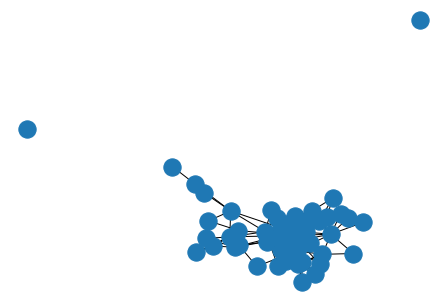

In [48]:
%matplotlib inline
nx.draw(G, with_labels=False)

In [49]:
from networkx.algorithms import community
from networkx import edge_betweenness_centrality as betweenness

def most_central_edge(G):

    centrality = betweenness(G, weight="weight")

    return max(centrality, key=centrality.get)

comp = community.girvan_newman(G, most_valuable_edge=most_central_edge)

communities =tuple(sorted(c) for c in next(comp))

In [50]:
# Extracting full articles from communities
cdf = []
for com in communities:
    df = pd.DataFrame()
    for art in com:
        x = data.loc[data['Title'] == art]
        df = df.append(x)
    cdf.append(df)

In [51]:
# Reducing each community down to an article 
min_coms = [] 
for com in cdf:
    min_time = min(com['Time Stamp'])
    df = pd.DataFrame()
    df = df.append(com.loc[com['Time Stamp'] == min_time])
    min_coms.append(df)

In [52]:
el = nx.DiGraph()
el.clear()

# Generating Lv and Huang graph 
lv = sorted([(x,list(x['Time Stamp'])) for x in min_coms], key = lambda x: x[1])
lv = [x[0] for x in lv]
for i in range(1, len(lv)):
    el.add_edge(list(lv[i-1]['Title'])[0], (list(lv[i]['Title'])[0]))

In [54]:
# Drawing the graph 
%matplotlib inline
nx.draw_kamada_kawai(el, with_labels=True)

Using matplotlib backend: TkAgg


In [14]:
# Generating NewsChain event line 

# Defining similarity between sub-events 
# Similarity = avg_pairwise_eos 
# Rules for drawing edge, if sim > theta, draw directed edge based on min time 
el = nx.DiGraph()
el.clear()
def pairwise_sim(df1, df2, model):
    t1 = [x + ': ' + y for x in df1['Title'] for y in df1['Abstract']]
    t2 = [x + ': ' + y for x in df2['Title'] for y in df2['Abstract']]
    v1 = utils.encode(t1, model)
    v2 = utils.encode(t2, model)
    tot = 0
    for x in v1:
        for y in v2:
            tot += utils.doc_sim(x, y) 
            
    return tot / (len(v1)  + len(v2))
            
for com1, rep1 in zip(cdf, min_coms):
    for com2, rep2 in zip(cdf, min_coms):
        bruh = pairwise_sim(com1, com2, roberta)
        if bruh > theta3: 
            if list(rep1['Time Stamp'])[0] > list(rep2['Time Stamp'])[0]:
                el.add_weighted_edges_from([(str(rep1['Title']), str(rep2['Title']), bruh)])
            else:
                el.add_weighted_edges_from([(str(rep2['Title']), str(rep1['Title']), bruh)])

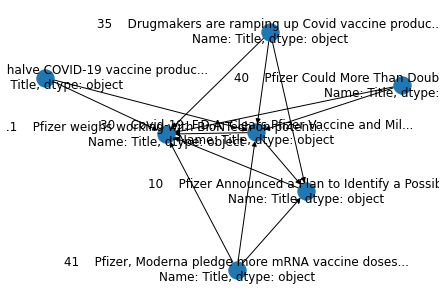

In [15]:
nx.convert_node_labels_to_integers(el, first_label=0, ordering='default', label_attribute=None)
nx.draw(el, with_labels = True)